In [194]:
import sys
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow.keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Lambda, dot, Activation, concatenate,  Layer, Embedding, Bidirectional
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback

In [195]:
dftweets = pd.read_csv('F:/ASDRP/data/stocktwits_SPXclassified.csv')
dftweets = dftweets[(dftweets['datetime']>= "2020-01-01") & (dftweets['datetime']< "2021-01-01")]
dftweets.head()
dftweets.shape

(95081, 7)

In [196]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
import re
import string 

def processTweet(tweet):
    tweet = re.sub(r'\&\w*;', '', tweet)
    tweet = re.sub('@[^\s]+','',tweet)
    tweet = re.sub(r'\$\w*', '', tweet)
    tweet = tweet.lower()
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    tweet = re.sub(r'#\w*', '', tweet)
    tweet = re.sub(r'[' + string.punctuation.replace('@', '') + ']+', ' ', tweet)
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    tweet = tweet.lstrip(' ') 
    tweet = re.sub('https', ' ', tweet)
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet

x = list(dftweets['message'])
for i in range(0,len(x)):
  x[i] = processTweet(x[i])

dftweets['Content'] = x

tokenizer = RegexpTokenizer(r'\w+')
regexptokenized = []
for i in list(dftweets['Content']):
  regexptokenized.append(tokenizer.tokenize(i))
#tokenizedcontent = tokenizer.tokenize(list(dftweets['content']))
print(regexptokenized[0:5])
tokenized = []


filtered_words = [word for word in regexptokenized if word not in stopwords.words('english')]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\emu4y\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\emu4y\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[['looking', 'for', 'more', 'green', 'tomorrow', 'but', 'could', 'weak', 'pop', 'get', 'closer', 'quad', 'witching', 'day', 'all', 'all', 'pretty', 'great', 'day', 'hope', 'you', 'all', 'made', 'some', 'nice', 'profits'], ['can', 'just', 'use', 'this', 'headline', 'for', 'the', 'next', 'years', '500', 'inches', 'higher', 'amid', 'stimulus', 'hopes', 'fed', 'commitment', 'keep', 'supporting', 'economy', 'futures', 'flat', 'stock', 'market', 'futures', 'open', 'close', 'news', 'html', 'source', 'androidappshare', 'and', 'after', 'this', 'remember', 'the', 'hit', 'intraday', 'all', 'time', 'high', 'didn', '3711', 'irs', 'ath', '3712', 'the', 'monday', 'before', 'last', 'headlines', 

In [197]:
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
stringcontent = ""
newcontent = []
for i in filtered_words:
  stringcontent = ""
  for j in i:
    stringcontent += lemmatizer.lemmatize(j) + " " 
  
  newcontent.append(stringcontent)
dftweets['Content'] = newcontent

In [198]:
dftweets

,Unnamed: 0,symbol,message,datetime,user,message_id,sentiment,Content
0,0,SPX,$spy $spx looking for more green tomorrow but ...,2020-12-16T21:15:21Z,226994,264863118,NaN,looking for more green tomorrow but could weak...
1,1,SPX,$SPY Can just use this Headline for the next 4...,2020-12-16T21:11:34Z,1078695,264861500,0.0,can just use this headline for the next year 5...
2,2,SPX,"$SPX +0.2%, $NDX +0.6% \nAll about FOMC and St...",2020-12-16T21:07:06Z,322291,264859501,NaN,all about fomc and stimulus lower rate for lon...
3,3,SPX,S&amp;P 500 Stocks At X-Day High [15-Dec]:\n\n...,2020-12-16T21:00:45Z,313661,264856112,NaN,500 stock day high dec day day day indexindica...
4,4,SPX,$SPY $SPX Wilshire 5000 Broad Measure Cycle is...,2020-12-16T21:00:20Z,21210,264855893,1.0,wilshire 5000 broad measure cycle bullish even...
...,...,...,...,...,...,...,...,...
95076,95076,SPX,Where Can We Find Market Opportunity? $SPX htt...,2020-01-01T02:13:00Z,296805,188619397,NaN,where can find market opportunity can find mar...
95077,95077,SPX,$SPY $ES_F $SPX $TVIX We&#39;ve just had one o...,2020-01-01T02:04:06Z,1585714,188619098,NaN,just had one our best video meeting yet discus...
95078,95078,SPX,$SPY $SPX In the market today\n\nTop Gainers\n...,2020-01-01T01:30:02Z,1117706,188617782,NaN,the market today top gainer fcel btai sndl uro...
95079,95079,SPX,$GLD whoa... Lol at it jump! $DJIA $SPX $SPY,2020-01-01T00:59:43Z,2837625,188616432,NaN,whoa lol jump


In [199]:
epochs = 10
embed_size = 128
batch_size = 16
maxlen = 75

In [200]:
dftweets = dftweets.dropna()

In [201]:
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in dftweets["Content"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)
import gensim

w2v_model = gensim.models.Word2Vec(sentences=X, size=embed_size, window=5, min_count=1)

In [202]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break

market -> 1
day -> 2
stock -> 3
week -> 4
time -> 5
trump -> 6
today -> 7
see -> 8
wa -> 9
get -> 10


In [203]:
X = pad_sequences(X, maxlen=maxlen)
y = dftweets['sentiment'].values

In [204]:
vocab_size = len(tokenizer.word_index)+1
#vocab_size = 43320
#vocab_size 43320 for the entire dataset
vocab_size

21632

In [205]:
def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, embed_size))
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [206]:
embedding_vectors = get_weight_matrix(w2v_model, word_index)

ipykernel_launcher:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [207]:
class AccuracyHistory(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        if logs.get('acc') is not None and logs.get('acc') > 0.95:
                print(f'Accuracy reached {logs.get("acc")*100:0.2f}. Stopping the training')
                self.model.stop_training = True

accuracyhist = AccuracyHistory()

In [208]:
from sklearn.model_selection import train_test_split
# dftweets = dftweets.dropna()
# X_train,X_test,y_train,y_test = train_test_split(dftweets.Content,dftweets.sentiment)

# t = Tokenizer(num_words = vocab_size)
# t.fit_on_texts(X_train)
# train_sequences = t.texts_to_sequences(X_train)
# train_padded = pad_sequences(train_sequences, maxlen=maxlen)
# t.fit_on_texts(X_test)
# test_sequences = t.texts_to_sequences(X_test)
# test_padded = pad_sequences(test_sequences, maxlen=maxlen)

# train_padded = np.array(train_padded)
# y_train = np.array(y_train)
# test_padded = np.array(test_padded)
# y_test = np.array(y_test)
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [209]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=embed_size, input_length=maxlen, weights = [embedding_vectors],trainable=False))
model.add(Bidirectional(LSTM(units=128)))
#model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [210]:
history = model.fit(X_train, y_train, batch_size = batch_size , validation_split = 0.3 , epochs = epochs)

Exception ignored in: <bound method SeekableUnicodeStreamReader.__del__ of <nltk.data.SeekableUnicodeStreamReader object at 0x0000021FE1F98FD0>>
Traceback (most recent call last):
  File "F:\anaconda3\lib\site-packages\nltk\data.py", line 1161, in __del__
    if not self.closed:
  File "F:\anaconda3\lib\site-packages\nltk\data.py", line 1175, in closed
    return self.stream.closed
AttributeError: 'SeekableUnicodeStreamReader' object has no attribute 'stream'
Epoch 1/10
922/922 [==============================] - 58s 60ms/step - loss: 0.6217 - accuracy: 0.6610 - val_loss: 0.6161 - val_accuracy: 0.6691
Epoch 2/10
922/922 [==============================] - 53s 57ms/step - loss: 0.6077 - accuracy: 0.6687 - val_loss: 0.6065 - val_accuracy: 0.6717
Epoch 3/10
922/922 [==============================] - 53s 57ms/step - loss: 0.6004 - accuracy: 0.6806 - val_loss: 0.6041 - val_accuracy: 0.6695
Epoch 4/10
922/922 [==============================] - 55s 59ms/step - loss: 0.5902 - accuracy: 0.6847 - 

In [211]:
model.save('modelv2.h5')

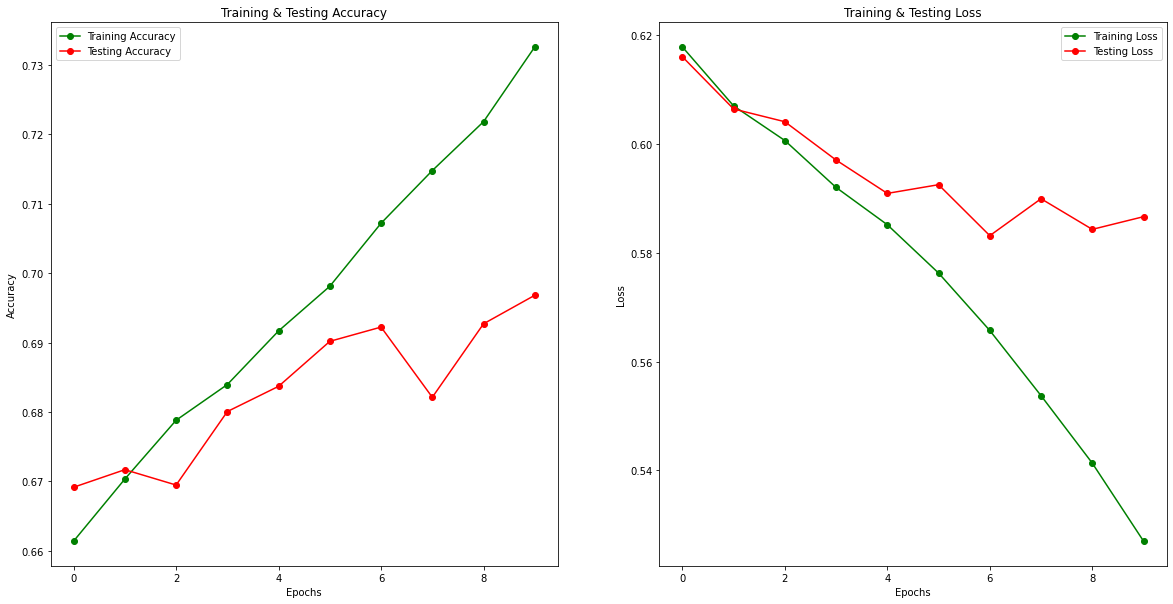

In [212]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [87]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 75, 128)           2768896   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 3,032,321
Trainable params: 263,425
Non-trainable params: 2,768,896
_________________________________________________________________


In [213]:
predicted = (model.predict(X_test) >= 0.5).astype("int")

In [214]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

         0.0       0.72      0.85      0.78      4547
         1.0       0.59      0.38      0.46      2478

    accuracy                           0.69      7025
   macro avg       0.65      0.62      0.62      7025
weighted avg       0.67      0.69      0.67      7025



In [90]:
dftweets['Content']

1        can just use this headline for the next year 5...
4        wilshire 5000 broad measure cycle bullish even...
5        this seems the retail buying frenzy point time...
6        the index above break the 2020 peak and make f...
7                             the whole market back green 
                               ...                        
95043    welcome black crash friday with long and stron...
95057    happy 2020 trading think going choppy year exp...
95071              sp500 current tlow thigh ratio1 ratio2 
95072    the year 2019 will remembered one the most pro...
95074                   you lost this year then astronaut 
Name: Content, Length: 28099, dtype: object

In [247]:
xna = pd.read_csv('F:/ASDRP/data/stocktwits_SPXclassified.csv')
xna = xna[xna['sentiment'].isna()]

In [248]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
import re
import string 

word_vectors = w2v_model.wv

def processTweet(tweet):
    tweet = re.sub(r'\&\w*;', '', tweet)
    tweet = re.sub('@[^\s]+','',tweet)
    tweet = re.sub(r'\$\w*', '', tweet)
    tweet = tweet.lower()
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    tweet = re.sub(r'#\w*', '', tweet)
    tweet = re.sub(r'[' + string.punctuation.replace('@', '') + ']+', ' ', tweet)
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    tweet = tweet.lstrip(' ') 
    tweet = re.sub('https', ' ', tweet)
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet

x = list(xna['message'])
for i in range(0,len(x)):
  x[i] = processTweet(x[i])

xna['Content'] = x

tokenizer = RegexpTokenizer(r'\w+')
regexptokenized = []
for i in list(xna['Content']):
  regexptokenized.append(tokenizer.tokenize(i))
#tokenizedcontent = tokenizer.tokenize(list(dftweets['content']))
print(regexptokenized[0:5])
tokenized = []


filtered_words = [word for word in regexptokenized if word not in stopwords.words('english')]
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
stringcontent = ""
newcontent = []
for i in filtered_words:
    stringcontent = ""
    for j in i:
        if j in word_vectors.vocab:
            stringcontent += lemmatizer.lemmatize(j) + " "
        else:
            stringcontent += " "
    newcontent.append(stringcontent)
xna['Content'] = newcontent

X2 = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in xna["Content"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X2.append(tmp)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\emu4y\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\emu4y\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[['looking', 'for', 'more', 'green', 'tomorrow', 'but', 'could', 'weak', 'pop', 'get', 'closer', 'quad', 'witching', 'day', 'all', 'all', 'pretty', 'great', 'day', 'hope', 'you', 'all', 'made', 'some', 'nice', 'profits'], ['all', 'about', 'fomc', 'and', 'stimulus', 'lower', 'rates', 'for', 'longer', 'fomc', 'stays', 'rates', 'and', 'keeps', 'asset', 'buy', 'programs', 'place', 'congress', 'moving', 'quickly', 'aid', 'details', '700', 'direct', 'checks', 'excess', 'ins', 'more', 'ppp', 'help', 'smbiz', 'stocks', 'move', 'new', 'athighs'], ['500', 'stocks', 'day', 'high', 'dec', 'day', 'day', 'day', 'indexindicators', 'com'], ['the', 'fed', 'summary', 'economic', 'projections', 'of

In [249]:
t = Tokenizer()
t.fit_on_texts(X2)

X2 = t.texts_to_sequences(X2)
X2 = pad_sequences(X2, maxlen=maxlen)

In [250]:
pred2 = (model.predict(X2) >= 0.5).astype("int")

In [251]:
xna['sentiment'] = pred2

In [254]:
xnew = pd.concat([xna, dftweets])

In [256]:
xnew.to_csv('stocktwits_SPXCwithw2vModel.csv')